<img src="http://certificate.tpq.io/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# EPAT Session 2

**Executive Program in Algorithmic Trading**

**_Vectorized Backtesting_**

Prof. Dr. Yves J. Hilpisch | The Python Quants GmbH | http://tpq.io

<a href="https://home.tpq.io/certificates/pyalgo" target="_blank"><img src="https://hilpisch.com/pyalgo_cover_shadow.png" width="300px" align="left"></a>

## Basic Imports

In [2]:
import math
import numpy as np
import pandas as pd
from pylab import plt
import cufflinks
np.set_printoptions(suppress=True)
cufflinks.set_config_file(offline=True)
plt.style.use('seaborn')
pd.set_option('mode.chained_assignment', None)
%config InlineBackend.figure_format = 'svg'

## Reading Financial Data

In [3]:
url = 'http://hilpisch.com/pyalgo_eikon_eod_data.csv'  # EOD data
# url = 'http://hilpisch.com/aiif_eikon_id_data.csv'  # intraday data

In [4]:
raw = pd.read_csv(url, index_col=0, parse_dates=True).dropna()

In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [6]:
rets = np.log(raw / raw.shift(1)).dropna()  # log returns

In [7]:
rets.head().round(4)

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-05,0.0017,0.0003,-0.0005,0.0059,0.0175,0.0026,0.0031,-0.0350,-0.0030,-0.0012,0.0096,-0.0009
2010-01-06,-0.0160,-0.0062,-0.0034,-0.0183,-0.0107,0.0007,0.0005,-0.0099,0.0031,0.0176,0.0240,0.0164
2010-01-07,-0.0019,-0.0104,-0.0097,-0.0172,0.0194,0.0042,0.0040,-0.0052,-0.0065,-0.0058,-0.0049,-0.0062
2010-01-08,0.0066,0.0068,0.0111,0.0267,-0.0191,0.0033,0.0029,-0.0500,0.0065,0.0037,0.0150,0.0050
2010-01-11,-0.0089,-0.0128,0.0057,-0.0244,-0.0159,0.0014,0.0017,-0.0325,0.0070,0.0144,0.0066,0.0132


## Regime Detection

... based on **unsupervised learning** (= only features, no labels).

Typical regimes are:

* low volatility, positive trend
* low volatility, negative trend
* high volatility, positive trend
* high volatility, negative trend

In [8]:
from sklearn.cluster import KMeans

In [9]:
model = KMeans(n_clusters=4)  # 1. step

### Features

In [10]:
symbol = '.SPX'

In [11]:
f = ['mom', 'vol']

In [12]:
data = pd.DataFrame(rets[symbol])

In [13]:
window = 20

In [14]:
data['mom'] = data[symbol].rolling(window).mean()

In [15]:
data['vol'] = data[symbol].rolling(window).std()

In [16]:
data.dropna(inplace=True)

In [17]:
data[f] = (data[f] - data[f].mean()) / data[f].std()

In [18]:
data[f].mean().round(6)

mom   -0.0
vol    0.0
dtype: float64

In [19]:
data[f].std().round(6)

mom    1.0
vol    1.0
dtype: float64

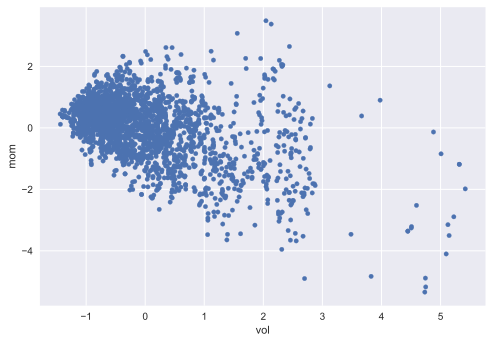

In [20]:
data[f].plot.scatter(x='vol', y='mom');

### Clustering

Clustering = unsupervised learning.

In [21]:
model.fit(data[f])  # 2. step

KMeans(n_clusters=4)

In [22]:
r = model.predict(data[f])  # 3. step

In [23]:
r

array([0, 0, 3, ..., 1, 1, 1])

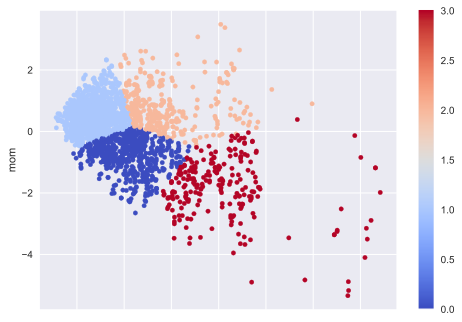

In [24]:
data[f].plot.scatter(x='vol', y='mom', c=r, cmap='coolwarm');

In [25]:
#plt.scatter?

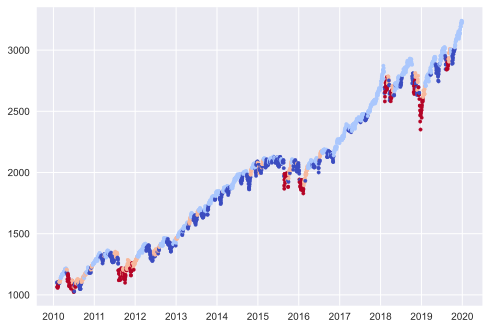

In [26]:
plt.scatter(x=data.index, y=raw.iloc[window:][symbol],
            marker='.', c=r, cmap='coolwarm');

## Advanced Trading Strategy

### Data Preprocessing

This is the point where the research plays the major role, in terms of coming up with valuable features for the prediction of future market movements ("**hard work**"):

In [27]:
symbol = 'EUR='

In [28]:
data = pd.DataFrame(raw[symbol])

In [29]:
data['r'] = np.log(data[symbol] / data[symbol].shift(1))

In [30]:
data['d'] = np.sign(data['r'])

In [31]:
data.dropna(inplace=True)

In [32]:
data['d'] = data['d'].astype(int)

In [33]:
data.head()

,EUR=,r,d
Date,,,
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1
2010-01-11,1.4513,0.006984,1


In [34]:
cols = list()
lags = 5
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    # data[col] = data['d'].shift(lag)
    data[col] = data['r'].shift(lag)
    cols.append(col)

In [35]:
data.head(8)

,EUR=,r,d,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2010-01-05,1.4368,-0.002988,-1,NaN,NaN,NaN,NaN,NaN
2010-01-06,1.4412,0.003058,1,-0.002988,NaN,NaN,NaN,NaN
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988,NaN,NaN,NaN
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058,-0.002988,NaN,NaN
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544,0.003058,-0.002988,NaN
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-0.006544,0.003058,-0.002988
2010-01-13,1.4510,0.001103,1,-0.001310,0.006984,0.006544,-0.006544,0.003058
2010-01-14,1.4502,-0.000551,-1,0.001103,-0.001310,0.006984,0.006544,-0.006544


In [36]:
data.dropna(inplace=True)

In [37]:
# data[cols] = data[cols].astype(int)

In [38]:
data.head()

,EUR=,r,d,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-0.006544,0.003058,-0.002988
2010-01-13,1.4510,0.001103,1,-0.001310,0.006984,0.006544,-0.006544,0.003058
2010-01-14,1.4502,-0.000551,-1,0.001103,-0.001310,0.006984,0.006544,-0.006544
2010-01-15,1.4382,-0.008309,-1,-0.000551,0.001103,-0.001310,0.006984,0.006544
2010-01-19,1.4298,-0.005858,-1,-0.008309,-0.000551,0.001103,-0.001310,0.006984


In [39]:
data_ = (data - data.mean()) / data.std()

In [40]:
data_.head()

,EUR=,r,d,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2010-01-12,1.938669,-0.214187,-1.007605,1.256582,1.177935,-1.142025,0.560551,-0.511372
2010-01-13,1.952831,0.214016,0.997222,-0.214533,1.255944,1.178974,-1.142118,0.560740
2010-01-14,1.945750,-0.079599,-1.007605,0.213539,-0.214803,1.256989,1.178748,-1.141841
2010-01-15,1.839535,-1.456061,-1.007605,-0.079986,0.213163,-0.213853,1.256758,1.178904
2010-01-19,1.765185,-1.021104,-1.007605,-1.456028,-0.080289,0.214140,-0.214000,1.256910


In [41]:
# 2 ** lags  # number of patterns

### Model Fitting (In-Sample)

... based on **supervised learning** (= features + labels).

In [42]:
from sklearn.naive_bayes import GaussianNB  # simple baseline algorithm
from sklearn.neural_network import MLPClassifier  # deep neural network
from sklearn.metrics import accuracy_score

In [43]:
model = GaussianNB()  # 1. step

In [44]:
model = MLPClassifier()  # 1. step

In [45]:
model = MLPClassifier(hidden_layer_sizes=[32], shuffle=False,
                     random_state=100, max_iter=1000)  # 1. step

In [46]:
model.fit(data_[cols], data['d'])  # 2. step

MLPClassifier(hidden_layer_sizes=[32], max_iter=1000, random_state=100,
              shuffle=False)

In [47]:
pred = model.predict(data_[cols])  # 3. step

In [48]:
pred

array([-1,  1, -1, ...,  1, -1, -1])

In [49]:
accuracy_score(data['d'], pred)

0.5482071713147411

In [50]:
model.predict_proba(data_[cols])

array([[0.50200339, 0.0105407 , 0.48745591],
       [0.45178986, 0.00457933, 0.54363082],
       [0.54449316, 0.00393598, 0.45157086],
       ...,
       [0.45485864, 0.01179672, 0.53334464],
       [0.56115579, 0.01091728, 0.42792692],
       [0.5328    , 0.01239785, 0.45480215]])

In [51]:
model.predict_proba(data_[cols]).sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

### Vectorized Backtesting (In-Sample)

In [52]:
data['p'] = pred

In [53]:
data['s'] = data['r'] * data['p']

In [54]:
data

,EUR=,r,d,lag_1,lag_2,lag_3,lag_4,lag_5,p,s
Date,,,,,,,,,,
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-0.006544,0.003058,-0.002988,-1,0.001310
2010-01-13,1.4510,0.001103,1,-0.001310,0.006984,0.006544,-0.006544,0.003058,1,0.001103
2010-01-14,1.4502,-0.000551,-1,0.001103,-0.001310,0.006984,0.006544,-0.006544,-1,0.000551
2010-01-15,1.4382,-0.008309,-1,-0.000551,0.001103,-0.001310,0.006984,0.006544,1,-0.008309
2010-01-19,1.4298,-0.005858,-1,-0.008309,-0.000551,0.001103,-0.001310,0.006984,-1,0.005858
...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1.1087,0.000090,1,0.000722,-0.003784,0.000810,-0.003414,0.000628,1,0.000090
2019-12-26,1.1096,0.000811,1,0.000090,0.000722,-0.003784,0.000810,-0.003414,-1,-0.000811
2019-12-27,1.1175,0.007094,1,0.000811,0.000090,0.000722,-0.003784,0.000810,1,0.007094


In [55]:
data[['r', 's']].sum().apply(np.exp)

r    0.772411
s    2.501969
dtype: float64

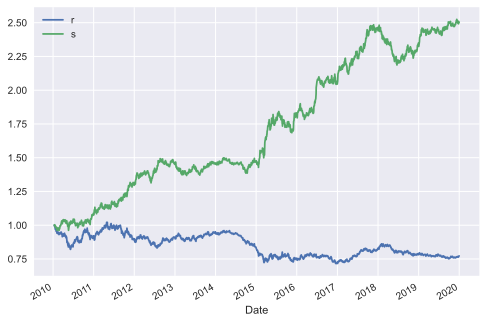

In [56]:
data[['r', 's']].cumsum().apply(np.exp).plot();

### Train-Test Split

In [57]:
split = int(len(data) * 0.8)

In [58]:
train = data.iloc[:split].copy()

In [59]:
mu, std = train[cols].mean(), train[cols].std()

In [60]:
train[cols] = (train[cols] - mu) / std

In [61]:
test = data.iloc[split:].copy()

In [62]:
test[cols] = (test[cols] - mu) / std

### Training (In-Sample)

In [63]:
model.fit(train[cols], train['d'])

MLPClassifier(hidden_layer_sizes=[32], max_iter=1000, random_state=100,
              shuffle=False)

In [64]:
accuracy_score(train['d'], model.predict(train[cols]))

0.5194223107569721

### Testing (Out-of-Sample)

In [65]:
pred = model.predict(test[cols])

In [66]:
accuracy_score(test['d'], pred)

0.4721115537848606

In [67]:
test['p'] = pred

In [68]:
test['s'] = test['r'] * test['p']

In [69]:
test[['r', 's']].sum().apply(np.exp)

r    0.929750
s    0.898233
dtype: float64

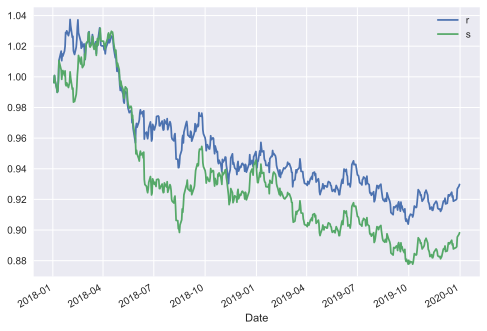

In [70]:
test[['r', 's']].cumsum().apply(np.exp).plot();

## Risk Factors Data File

In [71]:
factors = pd.read_csv('http://hilpisch.com/aiif_eikon_eod_factors.csv',
                      index_col=0, parse_dates=True)

In [72]:
factors.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 783 entries, 2017-01-02 to 2020-01-01
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   market      783 non-null    float64
 1   size        783 non-null    float64
 2   volatility  783 non-null    float64
 3   value       783 non-null    float64
 4   risk        783 non-null    float64
 5   growth      783 non-null    float64
 6   momentum    783 non-null    float64
dtypes: float64(7)
memory usage: 48.9 KB


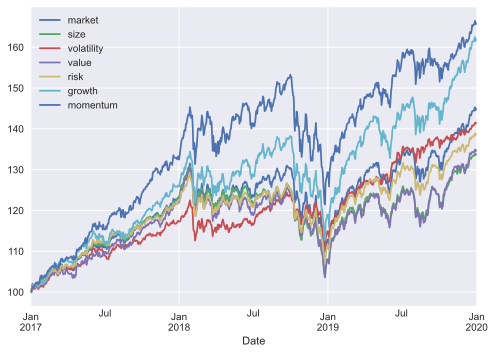

In [73]:
factors.normalize().plot();

<img src="http://certificate.tpq.io/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>